# Cuomo dataset analysis using crowflow

In [14]:
# # TODO: uncomment to download data
# # !pip install gdown
# import gdown

# cuomo_url = f'https://drive.google.com/uc?id=1ai2-eEwH2NiBQFbWj8XjdDTUmKwgmxeC'
# metadata_url = f'https://drive.google.com/uc?id=1Xp0gUAlhveeVMyHNTurJiGIEcnaXznXy'

# # Download the files - cuomo dataset and metadata
# gdown.download(cuomo_url, "cuomo_expr_matrix_with_MT_RP.csv", quiet=False)
# gdown.download(metadata_url, "metadata.csv", quiet=False)

In [1]:
import warnings
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import numpy as np

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

import pandas as pd

import pickle

/Users/macbookpro/Desktop/Desktop_rafa/RA/crow-flow-both/python/crowflow/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from sklearn.cluster import SpectralClustering 

In [4]:
from crowflow import (
    StochasticClusteringRunner,
    ParameterSearcher,
    GeneticAlgorithmFeatureSelector,
    plot_ga_fitness_evolution,
)

In [5]:
data = pd.read_csv(
    "data/cuomo_expr_matrix_with_MT_RP.csv", index_col="gene_name"
)

cell_metadata = pd.read_csv('data/metadata.csv', sep=',')
cell_metadata.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [6]:
# Transposing the raw data because scanpy expects genes on columns and cells on rows (opposite of Seurat).
adata = sc.AnnData(data.T)
adata.obs = cell_metadata

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Calculate quality control metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # Identify mitochondrial genes
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# Filter cells based on mitochondrial gene expression
adata = adata[adata.obs['pct_counts_mt'] < 5]

/Users/macbookpro/Desktop/Desktop_rafa/RA/crow-flow-both/python/crowflow/.venv/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


In [7]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=1000)

# Subset the data to include only highly variable genes, scale and run PCA
adata = adata[:, adata.var['highly_variable']]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

# Run harmony batch correction
sce.pp.harmony_integrate(adata, 'day.ident')
pca_embs = adata.obsm['X_pca_harmony']

# Run neighbors
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30, use_rep="X_pca_harmony") 
sc.tl.umap(adata)

# # Get scaled data as df.
scaled_data = adata.to_df()

/Users/macbookpro/Desktop/Desktop_rafa/RA/crow-flow-both/python/crowflow/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
/Users/macbookpro/Desktop/Desktop_rafa/RA/crow-flow-both/python/crowflow/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
/Users/macbookpro/Desktop/Desktop_rafa/RA/crow-flow-both/python/crowflow/.venv/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
2025-02-07 14:07:07,146 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-02-07 14:07:07,279 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-07 14:07:07,283 - harmonypy - INFO - Iteration 1 of 10
2025-02-07 14:07:07,347 - harmonypy - INFO - Iteration 2 of 10
2025-02-07 14:07:07,420 - harmony

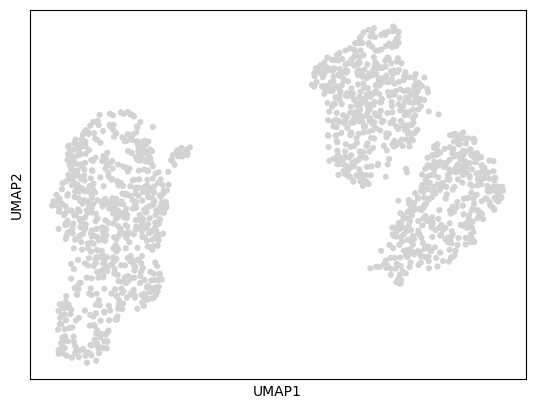

In [8]:
sc.pl.umap(adata)

## Analysis with crowflow

The `crowflow` package is highly versatile, enabling users to use their preferred clustering algorithm (e.g., any algorithm with a fit or fit_predict method or one that directly returns cluster labels).

To showcase `crowflow`‘s clustering evaluation capabilities, we will perform repeated stochastic clustering using Gaussian Mixture on the PCA embeddings. By passing `scikit-learn`’s `GaussianMixture` implementation to `StochasticClusteringRunner`, we can execute the algorithm multiple times (n_runs) while varying the random seed for each run.

After calling the `run` function, the returned dictionary includes Element-Centric Consistency (ECC) results and majority voting labels, representing the most likely cluster for each point. This can give more insights about how stable, reproducible, and thus trustworthy the clustering results are.

In [9]:
# Helper function to plot results on umap after clustering.
def visualise_ecc_labels(adata, ecc, ecc_adata_name, labels, labels_adata_name):
    adata.obs[ecc_adata_name] = ecc
    sc.pl.umap(adata, color=ecc_adata_name)

    adata.obs[labels_adata_name] = labels
    adata.obs[labels_adata_name] = adata.obs[labels_adata_name].astype("category")
    sc.pl.umap(adata, color=labels_adata_name)

In [10]:
from sklearn.mixture import GaussianMixture

Let's start by running Gaussian Mixture with 5 clusters (we are not using default because it's 1).

In [39]:
# Cluster with default parameter values
repeated_spectral_func = StochasticClusteringRunner(
    GaussianMixture, "random_state", n_runs=30, verbose=False, n_components=5
)
results_repeated_spectral = repeated_spectral_func.run(scaled_data)

In [40]:
np.median(results_repeated_spectral['ecc'])

np.float64(0.7211287537762378)

We get a median element-centric consistency of 0.72 when using default parameters and setting the number of clusters (n_components) to 5.

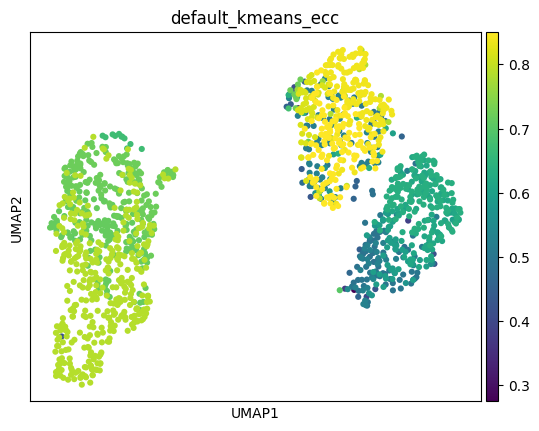

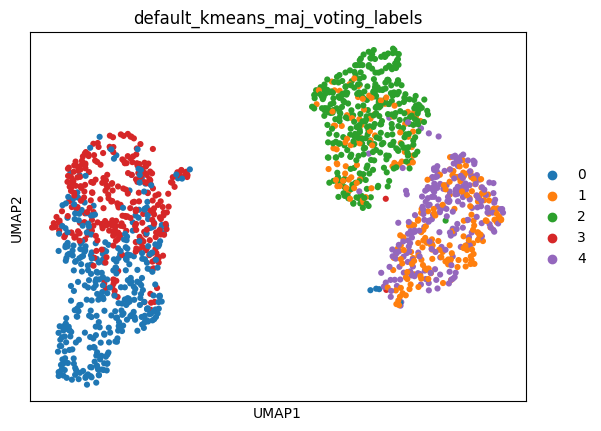

In [41]:
visualise_ecc_labels(
    adata,
    results_repeated_spectral["ecc"],
    "default_kmeans_ecc",
    results_repeated_spectral["majority_voting_labels"],
    "default_kmeans_maj_voting_labels",
)

Let’s try to find the optimal combination of the number of clusters and the initialization algorithm that results in the most stable partitions (i.e., highest ECC) using crow’s `ParameterSearcher` class.

In [46]:
# Find the optimal parameters based on ECC - similar to grid search.
param_grid = {"n_components": np.arange(3, 10, 1), "init_params": ["kmeans", "k-means++", "random"]}

parameter_searcher = ParameterSearcher(
    clustering_algo=GaussianMixture,
    parameter_name_seed="random_state",
    param_grid=param_grid,
    n_runs=30,
    verbose=False,
)
searcher_results_ecc_df, stochastic_clustering_results = parameter_searcher.run(scaled_data)

In [47]:
searcher_results_ecc_df.sort_values(by="median_ecc", ascending=False)

,params,ecc,median_ecc
9,"{'n_components': 6, 'init_params': 'kmeans'}","[0.43778422131850686, 0.6757446483097297, 0.67...",0.812531
15,"{'n_components': 8, 'init_params': 'kmeans'}","[0.5179784807582372, 0.8455466322673023, 0.507...",0.786575
12,"{'n_components': 7, 'init_params': 'kmeans'}","[0.4750959343742868, 0.7621155766869219, 0.541...",0.785302
0,"{'n_components': 3, 'init_params': 'kmeans'}","[0.7556640523224011, 0.7556640523224011, 0.784...",0.784335
3,"{'n_components': 4, 'init_params': 'kmeans'}","[0.7872019991498604, 0.7615795974159397, 0.866...",0.765460
18,"{'n_components': 9, 'init_params': 'kmeans'}","[0.4155249174392812, 0.7755325165474745, 0.466...",0.747072
6,"{'n_components': 5, 'init_params': 'kmeans'}","[0.5110093629750913, 0.6365694732303999, 0.722...",0.721129
1,"{'n_components': 3, 'init_params': 'k-means++'}","[0.4912468526118541, 0.5162032989600639, 0.534...",0.572357
4,"{'n_components': 4, 'init_params': 'k-means++'}","[0.437674824427448, 0.392475536626626, 0.50966...",0.509423
7,"{'n_components': 5, 'init_params': 'k-means++'}","[0.40027248016001094, 0.3533913888454163, 0.47...",0.442485


We get the highest median ECC (0.72 --> 0.82) when the number of clusters is 6 and the method used to initialize the weights, the means and the precisions is `kmeans`. Let's visualise the resulting partition and ECC for each element.

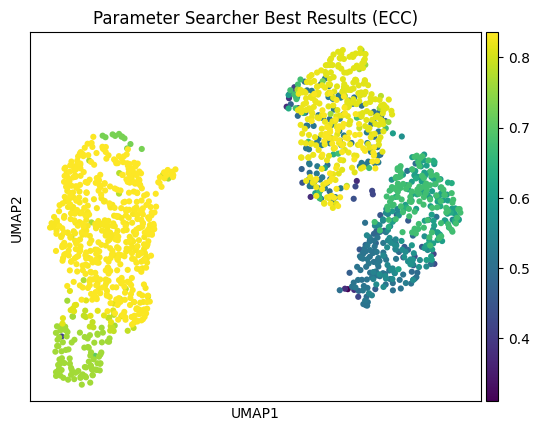

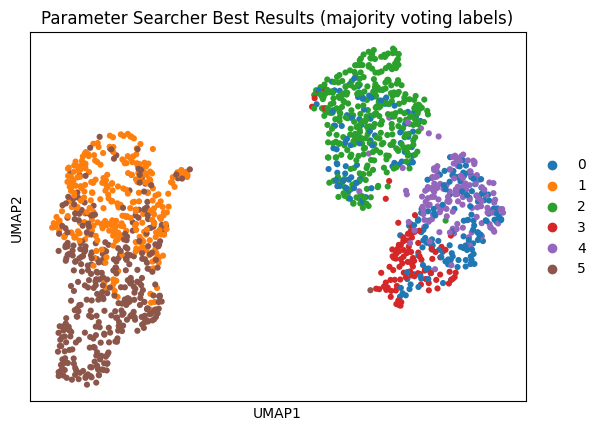

In [48]:
visualise_ecc_labels(
    adata,
    stochastic_clustering_results['n_components_6_init_params_kmeans']["ecc"],
    "Parameter Searcher Best Results (ECC)",
    stochastic_clustering_results['n_components_6_init_params_kmeans']["majority_voting_labels"],
    "Parameter Searcher Best Results (majority voting labels)",
)


We can try to find an optimal subset of features that result in the most stable partition using `crowflow`'s `GeneticAlgorithmFeatureSelector`. This class uses a genetic algorithm and repeated stochastic clustering to converge on the feature set that maximizes clustering robustness (ECC).

In [49]:
ga_fs = GeneticAlgorithmFeatureSelector(GaussianMixture, 'random_state', verbose=True, n_components=6, init_params="kmeans", n_generations_no_change=5)
ga_results = ga_fs.run(scaled_data)

Gen 0 - Best ECC: 0.8658
Gen 1 - Best ECC: 0.8658
Gen 2 - Best ECC: 0.8658
Gen 3 - Best ECC: 0.8658
Gen 4 - Best ECC: 0.8801
Gen 5 - Best ECC: 0.8801
Gen 6 - Best ECC: 0.8801
Gen 7 - Best ECC: 0.8801
Gen 8 - Best ECC: 0.8801
Gen 9 - Best ECC: 0.8801


In [55]:
np.median(ga_results['best_fitness_scr_result']['ecc'])

np.float64(0.8800789381300214)

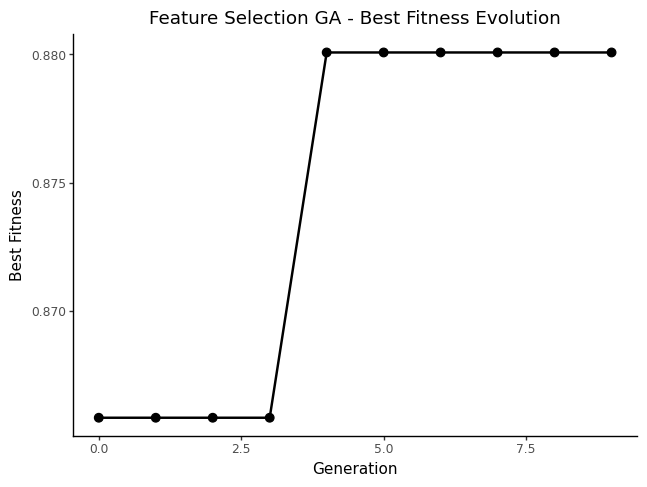

In [50]:
plot_ga_fitness_evolution(ga_results['history'])

In [56]:
len(ga_results['best_features'])

505

We were able to increase the median ECC from 0.82 to 0.88 by identifying a subset of genes (505/1000) using `crowflow`'s genetic algorithm feature selector.